In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse
import copy

plt.style.use('sarah_plt_style.mplstyle')

Lets use a non-ideal example image (includes other objects in the image, has some uneven brightness across the image, and does not have constant/periodic behavior across the image)

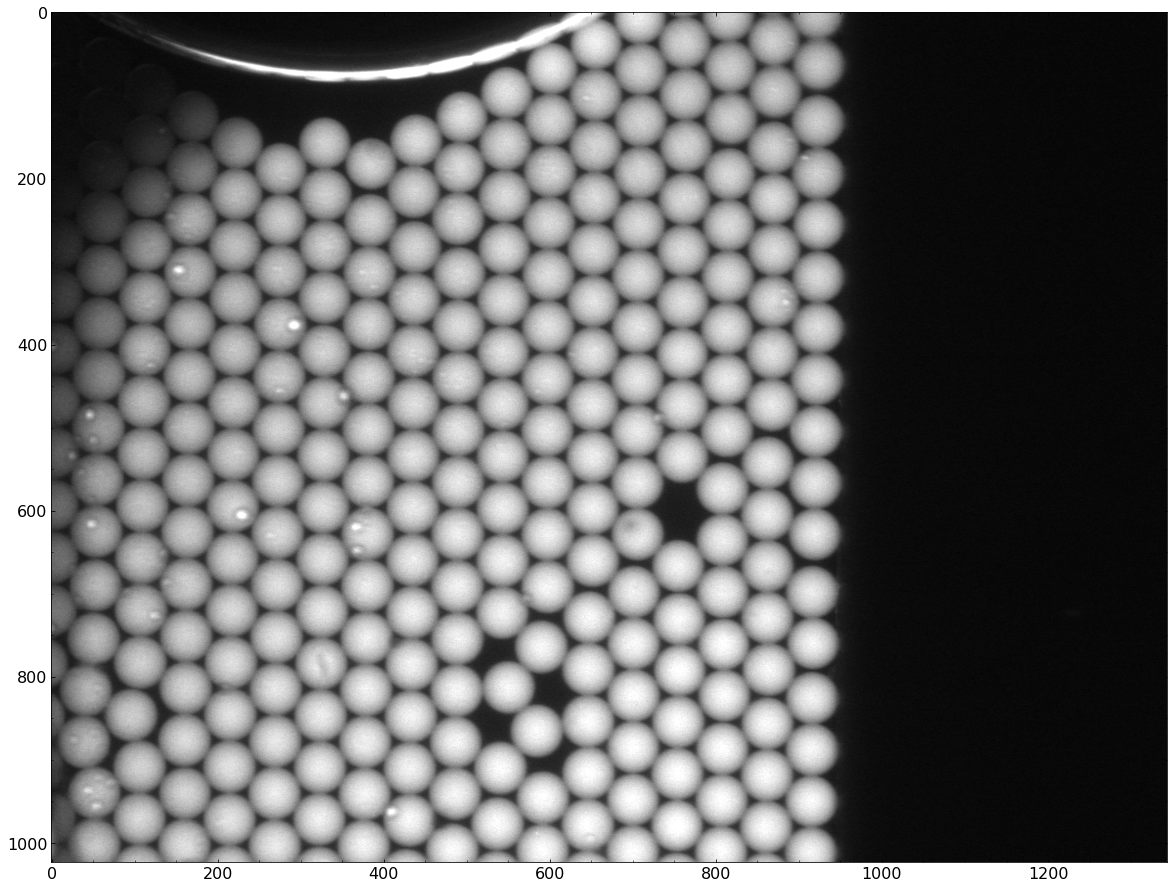

In [2]:
#change and get current working directory (cwd)
os.chdir('{}\Images'.format(os.getcwd()))
image_dir = os.getcwd()

#load image files
image = plt.imread('{}\\20220818\example_image.tif'.format(image_dir))

fig, ax = plt.subplots(figsize = (20, 20))
ax.imshow(image, cmap = 'gray')
plt.show()

HoughCircles appears to be the standard for using python to find circles in images, but it is pretty sensitive to the overall patterns of the image. For example it will pretty often put a circle around a whole group of droplets. THe only way I was able to get it to semi-consistently find droplets was to lower the maxRadius to 30, which defeats the point. If I simplify the image by binerizing it however, it does a great job of finding most of the droplets and getting actuate radi.

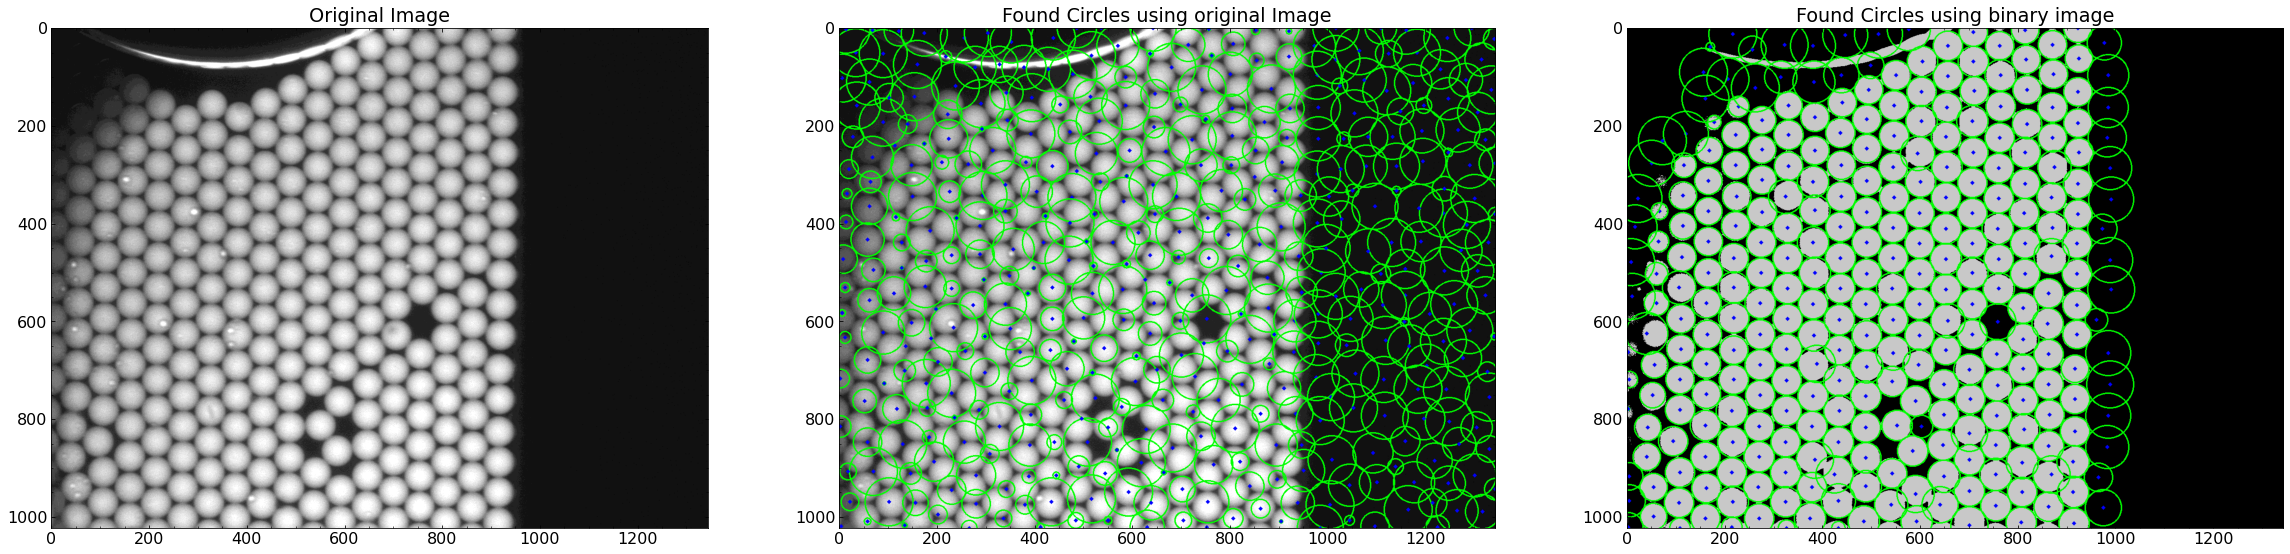

In [3]:
def find_bright_pixels(cutoff, pixel_value):
    if pixel_value > cutoff:
        return 1 #bright pixel
    else:
        return 0 #not bright pixel
    
find_bright_pixels = np.vectorize(find_bright_pixels, excluded=[0])

#load the image in a format compatible with HoughCircles
image = cv.imread('{}\\20220818\example_image.tif'.format(image_dir), 0)

#create a color version of the gray scale image to be able to plot circles over
color_img = cv.cvtColor(image,cv.COLOR_GRAY2BGR) * 17
#find circles using a Hough transform
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
circles = np.uint16(np.around(circles))

for i in circles[0,:]: #for each found circle
    cv.circle(color_img,(i[0],i[1]),i[2],(0,255,0),2) #add a green outline to the color image
    cv.circle(color_img,(i[0],i[1]),2,(0,0,255),3) #add a blue center point to the color image

#binerize the image and find cicrles in the new image
th, bin_image = cv.threshold(image, 6, 1, cv.THRESH_BINARY)
bin_color_img = cv.cvtColor(bin_image,cv.COLOR_GRAY2BGR) *200
bin_circles = cv.HoughCircles(bin_image, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
bin_circles = np.uint16(np.around(bin_circles))

for i in bin_circles[0,:]:
    cv.circle(bin_color_img,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(bin_color_img,(i[0],i[1]),2,(0,0,255),3)

fig, axs = plt.subplots(1, 3, figsize = (40,20))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original Image')
axs[1].imshow(color_img, cmap = 'gray')
axs[1].set_title('Found Circles using original Image')
axs[2].imshow(bin_color_img, cmap = 'gray')
axs[2].set_title('Found Circles using binary image')

plt.show()

Now we need to figure out how to filter out the extra circles that are not highlighting droplets. To do this we will find all of the points in a given circle, then find the average pixel value (in the binary image) and remove any circles with an average value less than 0.9.

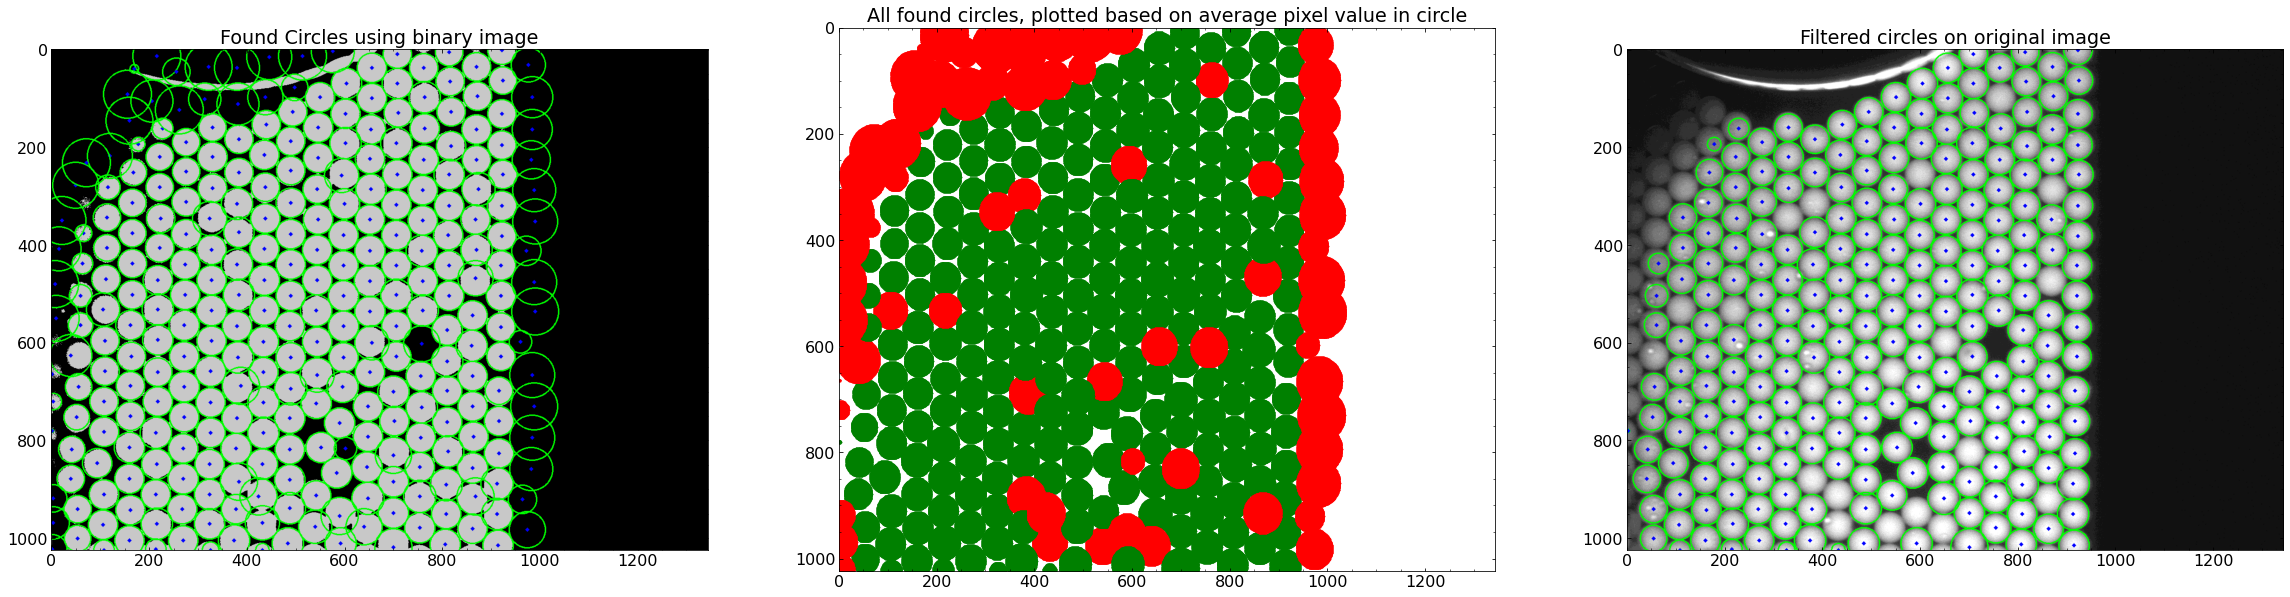

In [7]:
def find_pixels_in_circle(cir_par):
    #returns a list of points inside a circle with a given center point and radius
    #does not include any points which are off the edge of the image
    points = []
    cx, cy, r = cir_par
    for y in range(-1 *  r, +r+1):
        x = (r**2 - y**2)**0.5

        x1 = int(-x + cx)
        x2 = int(+x + cx)
    
        y = y + cy
        for x in range(x1, x2):
            if x < 1344 and y < 1024: #don't keep a point if it falls outside the image size
                points.append([x,y])
    return points 

color_img = cv.cvtColor(image,cv.COLOR_GRAY2BGR) * 17 #regen a new color image to plot the filtered circles on

fig, axs = plt.subplots(1, 3, figsize = (40,10))

radi = []
for i in bin_circles[0,:]: #for each found circle
    points = find_pixels_in_circle(i) #list off all points in the circle
    values = [bin_image[point[1], point[0]] for point in points] #list of pixel vales in the binary image at those points
    if np.mean(values) > 0.9:
        axs[1].scatter([point[0] for point in points],[point[1] for point in points], color = 'green', s=1)
        cv.circle(color_img,(i[0],i[1]),i[2],(0,255,0),2)
        cv.circle(color_img,(i[0],i[1]),2,(0,0,255),3)
        radi.append(i[2])
    else:
        axs[1].scatter([point[0] for point in points],[point[1] for point in points], color = 'red', s=1)

axs[0].imshow(bin_color_img, cmap = 'gray')
axs[0].set_title('Found Circles using binary image')
axs[2].imshow(color_img, cmap = 'gray')
axs[2].set_title('Filtered circles on original image')
axs[1].set_title('All found circles, plotted based on average pixel value in circle')
axs[1].set_xlim(0, 1344)
axs[1].set_ylim(0, 1024)
axs[1].invert_yaxis()

plt.show()

[29, 29, 28, 30, 29, 29, 29, 29, 29, 27, 30, 29, 29, 28, 31, 30, 29, 30, 30, 30, 30, 28, 29, 29, 28, 30, 30, 28, 31, 30, 30, 30, 30, 30, 30, 29, 30, 28, 28, 30, 29, 29, 28, 28, 31, 30, 29, 29, 30, 30, 30, 29, 29, 28, 30, 30, 27, 33, 31, 30, 30, 30, 30, 29, 29, 27, 31, 31, 30, 30, 30, 30, 30, 31, 31, 30, 30, 30, 30, 30, 29, 31, 30, 30, 30, 30, 28, 26, 29, 30, 30, 29, 31, 31, 31, 30, 30, 30, 29, 29, 27, 31, 29, 29, 31, 30, 30, 30, 30, 28, 21, 33, 32, 31, 30, 30, 30, 30, 29, 32, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 30, 29, 31, 30, 30, 29, 29, 27, 31, 30, 32, 31, 30, 30, 29, 31, 31, 30, 29, 29, 21, 31, 31, 30, 30, 30, 25, 32, 31, 30, 30, 30, 30, 28, 32, 31, 31, 30, 30, 30, 23, 32, 32, 31, 30, 32, 32, 31, 31, 31, 31, 30, 30, 32, 32, 31, 30, 30, 30, 32, 31, 30, 30, 31, 32, 32, 32, 31, 14, 32, 31, 31, 30, 30, 30, 30, 29, 33, 32, 32, 32, 32, 30, 33, 32, 32, 30, 32, 30, 30, 29, 33, 32, 32, 31, 32, 38, 21, 17, 21, 14, 3]


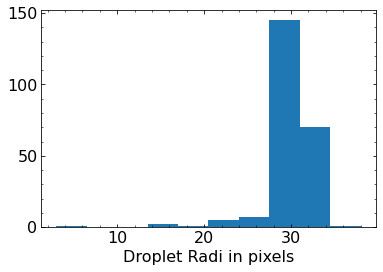

In [5]:
print(radi)
plt.hist(radi)
plt.xlabel('Droplet Radi in pixels')
plt.show()